In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from glob import glob

In [2]:
from keras.datasets import cifar10
from keras.models import Model,Sequential
from keras.layers import Dense, Input, Lambda, Reshape, Dropout, Flatten, Activation
from keras.optimizers import SGD, Adam
from keras import losses
import keras.backend as K
from keras import initializers
from keras.layers.normalization import BatchNormalization
from keras import metrics
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D 
from keras import regularizers

Using TensorFlow backend.


# Loading Some of SVHN Test Set Images 

In [53]:
images_path = glob('./Images/*.png')
Images = [] 
for path in images_path:
    Images.append(imread(path))
Images = np.array(Images) / 255

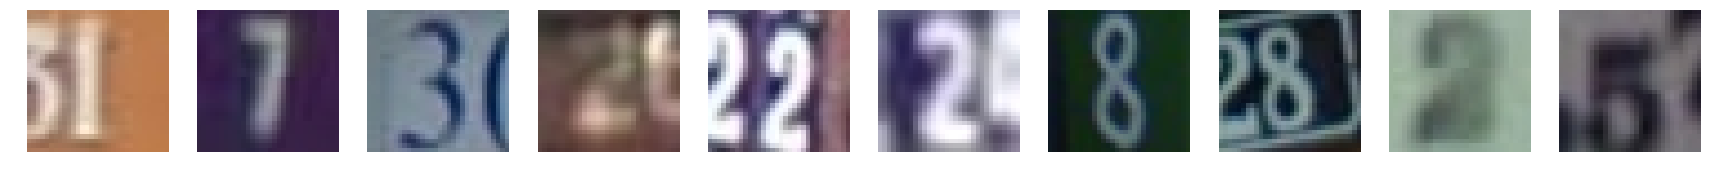

In [54]:
f, ax = plt.subplots(1,10, figsize=(30,10))
for i in range(10):
    ax[i].imshow(Images[i])
    ax[i].axis('Off')
plt.show()

# Variational AutoEncoder for SVHN

In [55]:
def vae_loss(y_true,y_pred):
    
    recontruction_loss = K.mean(K.binary_crossentropy(y_pred, y_true))
    latent_loss = -0.5 * K.mean(1 + z_std_sq_log - K.square(z_mean) - K.exp(z_std_sq_log), axis=-1 )
    return recontruction_loss + 0.01*latent_loss

In [56]:
def recon_error(y_true, y_pred):
    return K.sum(K.square(y_true - y_pred)) / K.sum(K.square(y_true))

In [57]:
# Dimension of Latent Representation
dim_representation = 100

b_f = 128
# ENCODER
input_vae = Input(shape=(32,32,3))

encoder_hidden1 = Conv2D(filters = b_f, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(input_vae)
encoder_hidden1 = BatchNormalization()(encoder_hidden1)
encoder_hidden1 = Activation('relu')(encoder_hidden1)

encoder_hidden2 = Conv2D(filters = b_f*2, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(encoder_hidden1)
encoder_hidden2 = BatchNormalization()(encoder_hidden2)
encoder_hidden2 = Activation('relu')(encoder_hidden2)

encoder_hidden3 = Conv2D(filters = b_f*4, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(encoder_hidden2)
encoder_hidden3 = BatchNormalization()(encoder_hidden3)
encoder_hidden3 = Activation('relu')(encoder_hidden3)

encoder_hidden4 = Flatten()(encoder_hidden3)

# Latent Represenatation Distribution, P(z)
z_mean = Dense(dim_representation, activation='linear', 
                          kernel_initializer= initializers.he_normal(seed=None))(encoder_hidden4)
z_std_sq_log = Dense(dim_representation, activation='linear', 
                          kernel_initializer= initializers.he_normal(seed=None))(encoder_hidden4)

# Sampling z from P(z)
def sample_z(args):
    mu, std_sq_log = args
    epsilon = K.random_normal(shape=(K.shape(mu)[0], dim_representation), mean=0., stddev=1.)
    z = mu + epsilon * K.sqrt( K.exp(std_sq_log)) 
    return z

z = Lambda(sample_z)([z_mean, z_std_sq_log])


# DECODER
decoder_hidden0 = Dense(K.int_shape(encoder_hidden4)[1], activation='relu', kernel_initializer= initializers.he_normal(seed=None))(z)
decoder_hidden0 = Reshape(K.int_shape(encoder_hidden3)[1:])(decoder_hidden0)

decoder_hidden1 = Conv2DTranspose(filters = b_f*4, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(decoder_hidden0)
decoder_hidden1 = BatchNormalization()(decoder_hidden1)
decoder_hidden1 = Activation('relu')(decoder_hidden1)

decoder_hidden2 = Conv2DTranspose(filters = b_f*2, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(decoder_hidden1)
decoder_hidden2 = BatchNormalization()(decoder_hidden2)
decoder_hidden2 = Activation('relu')(decoder_hidden2)

decoder_hidden3 = Conv2DTranspose(filters = b_f, kernel_size = 2, strides = (2,2), padding = 'valid', kernel_initializer = 'he_normal' )(decoder_hidden2)
decoder_hidden3 = BatchNormalization()(decoder_hidden3)
decoder_hidden3 = Activation('relu')(decoder_hidden3)

decoder_hidden4 = Conv2D(filters = 3, kernel_size= 1, strides = (1,1), padding='valid', kernel_initializer = 'he_normal')(decoder_hidden3)
decoder_hidden4 = Activation('sigmoid')(decoder_hidden4)
# MODEL
VAE = Model(input_vae, decoder_hidden4)

In [58]:
# Printing the Summary of the Model
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 16, 16, 128)  1664        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 16, 16, 128)  512         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 16, 16, 128)  0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
conv2d_6 (

In [59]:
# Encoder Model
Encoder = Model(inputs = input_vae, outputs = [z_mean, z_std_sq_log])
no_of_encoder_layers = len(Encoder.layers)
no_of_vae_layers = len(VAE.layers)

# Decoder Model
decoder_input = Input(shape=(dim_representation,))
decoder_hidden = VAE.layers[no_of_encoder_layers+1](decoder_input)

for i in np.arange(no_of_encoder_layers+2 , no_of_vae_layers-1):
    decoder_hidden = VAE.layers[i](decoder_hidden)
decoder_hidden = VAE.layers[no_of_vae_layers-1](decoder_hidden)
Decoder = Model(decoder_input,decoder_hidden )

In [91]:
# Optimizer for Training Neural Network
optimizer_ = Adam(lr=0.0001) # Best learning rate = 0.00001

# Compiling the VAE for Training.
VAE.compile(optimizer=optimizer_, loss = vae_loss, metrics = [recon_error])
VAE.load_weights('vae_weights.h5')

# Reconstructed Images

In [61]:
z_mu, z_std = Encoder.predict(Images)
eps = np.random.normal(0,1, (Images.shape[0], dim_representation))
z = z_mu + eps * np.sqrt( np.exp(z_std))
Reconstructed = Decoder.predict(z)

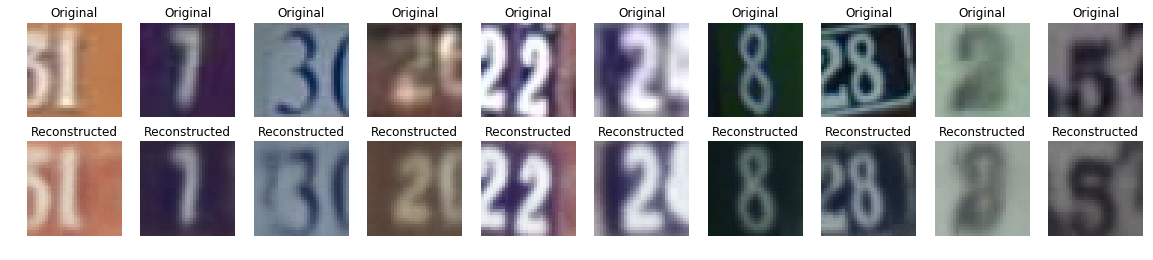

In [116]:
z_mu, z_std = Encoder.predict(Images)
eps = np.random.normal(0,1, (Images.shape[0], dim_representation))
z = z_mu + eps * np.sqrt( np.exp(z_std))
Reconstructed = Decoder.predict(z)

f, ax = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    # display original
    ax[0,i].imshow(Images[i])
    ax[0,i].set_title('Original')
    ax[0,i].axis('Off')
    # display re\construction
    ax[1,i].imshow(Reconstructed[i])
    ax[1,i].set_title('Reconstructed')
    ax[1,i].axis('Off')

plt.show()

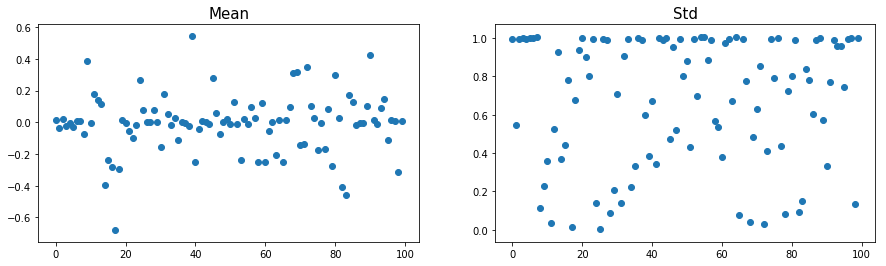

In [70]:
# Showing if The Mean and Std encoded by ENCODER is close to 0 and 1 respectively.

f,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].scatter( range(z_mu.shape[1]), np.mean(z_mu, axis=0) )
ax[0].set_title('Mean', size=15)
ax[1].scatter( range(z_std.shape[1]), np.mean( np.exp(z_std), axis=0))
ax[1].set_title('Std', size=15)
plt.show()

** Generating New Samples from VAE (SVHN) by input random number **

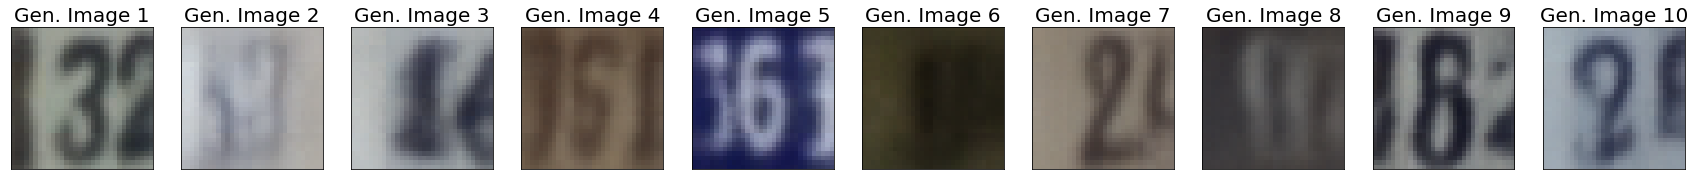

In [113]:
# K.set_learning_phase(0)
n = 10
eps = np.random.normal(0, 1, size=(n, dim_representation))
decoded_imgs = Decoder.predict(eps)

  # how many digits we will display
plt.figure(figsize=(30,10))
for i in range(n):
    
    # Generated Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title('Gen. Image '+ str(i+1), size=20)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
# plt.savefig('Generated.png')
# plt.close()
plt.show()